In [1]:
# only run once
!conda create -n resnet_fl_2host python=3 anaconda -y

Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /usr/local/anaconda3/envs/resnet_fl_2host

  added / updated specs:
    - anaconda
    - python=3


The following NEW packages will be INSTALLED:

  alabaster          pkgs/main/noarch::alabaster-0.7.12-py_0
  anaconda           pkgs/main/osx-64::anaconda-2020.11-py38_0
  anaconda-client    pkgs/main/osx-64::anaconda-client-1.7.2-py38_0
  anaconda-project   pkgs/main/noarch::anaconda-project-0.8.4-py_0
  applaunchservices  pkgs/main/noarch::applaunchservices-0.2.1-py_0
  appnope            pkgs/main/osx-64::appnope-0.1.0-py38_1001
  appscript          pkgs/main/osx-64::appscript-1.1.1-py38haf1e3a3_0
  argh               pkgs/main/osx-64::argh-0.26.2-py38_0
  argon2-cffi        pkgs/main/osx-64::argon2-cffi-20.1.0-py38haf1e3a3_1
  asn1crypto         pkgs/main/noarch::asn1crypto-1.4.0-py_0
  astroid            p

Preparing transaction: done
Verifying transaction: \ WARNING conda.core.path_actions:verify(963): Unable to create environments file. Path not writable.
  environment location: /Users/nicolai/.conda/environments.txt

done
Executing transaction: / WARNING conda.core.envs_manager:register_env(52): Unable to register environment. Path not writable or missing.
  environment location: /usr/local/anaconda3/envs/resnet_fl_2host
  registry file: /Users/nicolai/.conda/environments.txt
done
#
# To activate this environment, use
#
#     $ conda activate resnet_fl_2host
#
# To deactivate an active environment, use
#
#     $ conda deactivate



In [1]:
# activate conda environment to access pysyft
!source /usr/local/anaconda3/bin/activate resnet_fl_2host

In [3]:
# not necessary after 2nd run
!conda install -c pytorch pytorch -y

Solving environment: done

# All requested packages already installed.



In [4]:
# not necessary after 2nd run
!pip install syft==0.2.9

In [2]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import syft as sy

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/anaconda3/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.4.so'


In [3]:
hook = sy.TorchHook(torch)
#host1 = sy.VirtualWorker(hook, id="host1")
#host2 = sy.VirtualWorker(hook, id="host2")

In [5]:
class Arguments():
    def __init__(self):
        self.batch_size = 4
        self.test_batch_size = 100
        self.epochs = 5
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = True

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

torch.set_num_threads(4)

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

def load_split_train_test(datadir, valid_size = .2, use_federated_dataloader=True):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
   
    loaded_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
    train_set, val_set = torch.utils.data.random_split(loaded_dataset, [1680, 420])
    num_train = len(loaded_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    if use_federated_dataloader: 
        train_loader = sy.FederatedDataLoader(
            loaded_dataset.federate((host1, host2)),
            batch_size=args.batch_size, 
            **kwargs
        )
    else :
        train_loader = torch.utils.data.DataLoader(
            loaded_dataset,
            batch_size=args.batch_size,
            sampler=train_sampler,
            #shuffle=True, 
            **kwargs
        )
    test_loader = torch.utils.data.DataLoader(
        loaded_dataset,
        batch_size=args.test_batch_size,
        **kwargs
    )
    
    return {'train': train_loader, 'val': test_loader}, {'train': len(train_idx), 'val':len(test_idx)}, loaded_dataset.classes

In [6]:
data_dir = "../../datasets/UCMerced_LandUse/Images"
dataloaders, dataset_sizes, class_names = load_split_train_test(data_dir, .2, True)
print(dataloaders['val'], dataset_sizes, class_names)

<torch.utils.data.dataloader.DataLoader object at 0x7f91053f9f50> {'train': 1680, 'val': 420} ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [7]:
torch.set_num_threads(4)

In [24]:
def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get().item() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss))

In [13]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
def train_client_model(args, model, device, dataloader, optimizer, local_epochs):
    # train
    model.train()
    for (data, traget) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        in_size = data.size(0)
        running_loss = loss.item() * in_size
        
    # eval
    

In [ ]:
LOCAL_EPOCHS = 5

#clients is array of dataloaders
def train_fedavg_model(args, model, device, clients, optimizer, epochs):
    # iterate throigh epochs
    for iter in range(epoch):
        
        # get random subset of clients
        client_subset = []
        
        # train each of the clients
        models = []
        for client in client_subset:
            client_model = train_client_model(args, model, device, dataloader, optimizer, LOCAL_EPOCHS)
            models.append(client_model)
            
        # average clients params
        with torch.no_grad():
            for m in models:
            

In [27]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=5, batch_size=4):
    %matplotlib inline
    import pylab as pl
    from IPython import display
    def live_plot(data):
        pl.plot(data)
        display.clear_output(wait=True)
        display.display(pl.gcf())
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_values, accuracy_values, loss_values_val, accuracy_values_val = [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss_train, running_loss_val = 0, 0
        running_corrects_train, running_corrects_val = 0, 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(tqdm(dataloaders['train'])):
            # NEW) send model to correct worker
            if i>=1680:
                break
            model.send(inputs.location)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase

                loss.backward()
                optimizer.step()


            # get model (with gradients)
            model.get()
            # statistics
            running_loss_train += loss.get().item() * batch_size
            running_corrects_train += torch.sum(preds == labels.data).get()
            #print(preds.get(),labels.get())
            #running_loss_train += loss.item() * batch_size
            #running_corrects_train += torch.sum(preds == labels.data)
        #scheduler.step()
        
        epoch_loss_train = running_loss_train / (dataset_sizes['train']+dataset_sizes['val'])
        epoch_acc_train = running_corrects_train.double() / (dataset_sizes['train']+dataset_sizes['val'])
        loss_values.append(epoch_loss_train)
        accuracy_values.append(epoch_acc_train.item())
        live_plot(loss_values)
        print(loss_values,)
        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        model.eval()   # Set model to evaluate mode
        for i, (inputs, labels) in enumerate(tqdm(dataloaders['train'])):
            if i<=1680:
                continue
            model.send(inputs.location)
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss_val += loss.get() * batch_size
            running_corrects_val += torch.sum(preds == labels.data).get()
            #running_loss_val += loss * batch_size
            #running_corrects_val += torch.sum(preds == labels.data)
            model.get()
        epoch_loss_val = running_loss_val / dataset_sizes['val']
        epoch_acc_val = running_corrects_val / dataset_sizes['val']
        loss_values_val.append(epoch_loss_val)
        accuracy_values_val.append(epoch_acc_val)
        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        # deep copy the model
        if epoch_acc_train > best_acc:
            best_acc = epoch_acc_train
            best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #print(loss_values, accuracy_values, loss_values_val, accuracy_values_val)
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {"tloss":loss_values, "valloss":loss_values_val, "tacc":accuracy_values,"valacc":accuracy_values_val}

In [19]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet34(pretrained=True)
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_ftrs, n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [14]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        from collections import OrderedDict
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(5, 5))
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=(5, 5))
        self.linear1 = nn.Linear(64 * 24 * 24, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, n_classes)                                
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2)
        #x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2, stride=2)
        x = x.view(-1, 64 * 24 * 24)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [27]:
from torchvision import models
from torch.optim import lr_scheduler
import time
import os
import copy

model = Net(len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
#model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)
#torch.save(model.state_dict(), "resnet_fl2.pt")

In [34]:
from torchvision import models
from torch.optim import lr_scheduler
import time
import os
import copy

model = CNN(len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

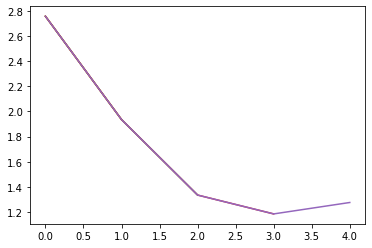

[2.75581578003108, 1.9350535738559709, 1.3350528363280354, 1.1852085919742517, 1.2759987884298676]
Train Loss: 1.2760 Train Acc: 0.6343



Val Loss: 0.0000 Val Acc: 0.0000

Training complete in 23m 49s
Best val Acc: 0.670476


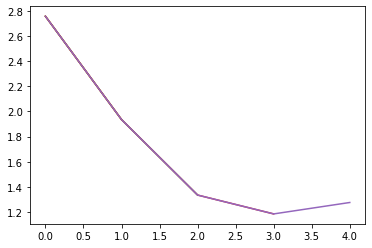

In [35]:
from tqdm.notebook import tqdm
model, stats_dict = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=5, batch_size=args.batch_size)
torch.save(model.state_dict(), "lenet_fl2.pt")

In [30]:
'''
for epoch in range(1, args.epochs + 1):
    train(args, model, device, dataloaders['train'], optimizer, epoch)
    test(args, model, device, dataloaders['val'])

if (args.save_model):
    torch.save(model.state_dict(), "resnet_fl.pt")'''

'\nfor epoch in range(1, args.epochs + 1):\n    train(args, model, device, dataloaders[\'train\'], optimizer, epoch)\n    test(args, model, device, dataloaders[\'val\'])\n\nif (args.save_model):\n    torch.save(model.state_dict(), "resnet_fl.pt")'